- Core Libs in Transformer
    - Datasets
    - Tokenizer
    - Transformers
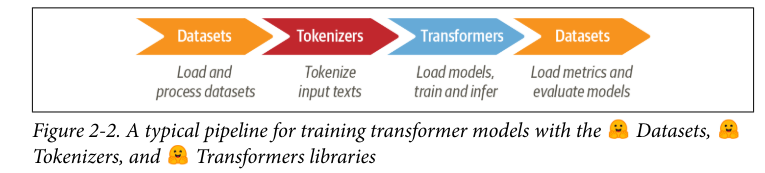

## Dataset
- `from datasets import list_datasets`
- lists available datasets

In [6]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f'the number of datasets: {len(all_datasets)}')

the number of datasets: 139500


## Load a dataset
- dataset package
- pip install dataset

In [4]:
from datasets import load_dataset

emotions = load_dataset('emotion')
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [9]:
emotions['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [12]:
train_ds = emotions['train']
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [13]:
train_ds.column_names

['text', 'label']

- datasets are based on apache arrow

In [14]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

### Load data files from computer
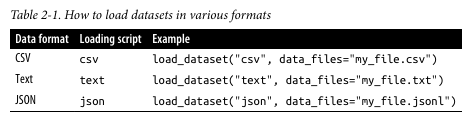

- Load data from a url

In [ ]:
from datasets import load_dataset
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
# download the file to disk
!wget {dataset_url}

# load the local file (csv) to notebook
emotions_local = load_dataset(
    "csv", data_files="train.txt", 
    sep=";", names=["text", "label"]
)

## Convert the datasets to dataframes
- .set_format() method used to convert the pyarrow data to pandas
- int2str() method to convert the label(int) to text

In [6]:
import pandas as pd

emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [12]:
def label_int2str(row):
    # the dataset featues are a list
    # emotions['train'].features['label']
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Class distribution

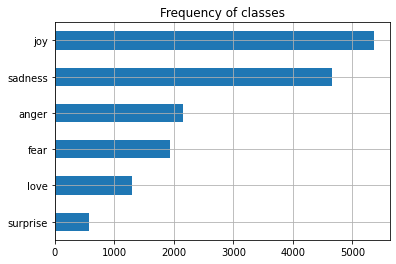

In [18]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of classes')
plt.grid()
plt.show()

- address the imbalanced distribution
    - under sample the majority class
    - over sample the majority class
    - gahter more data for minority class
- imbalance learn lib: https://oreil.ly/5XBhb

### Tweet lenghts

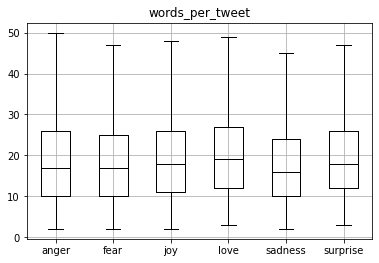

In [26]:
df['words_per_tweet'] = df['text'].apply(lambda x: len(x.split()))
df.boxplot(
    'words_per_tweet', by = 'label_name',
    showfliers=False, color='black'
)
plt.suptitle('')
plt.xlabel('')
plt.show()

## Text to tokens
- assign numbers 
    - words / characters / tokens (words may split)
    
### Character level tokens

In [12]:
# tokenize a text on character level
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print('characters')
print(tokenized_text)
print('\n')

token2idx = {ch: id for id, ch in enumerate(sorted(set(tokenized_text)))}
print('token ids')
print(token2idx)
print('\n')

# print the tokenized text
input_ids = [token2idx[char] for char in text]
print('input ids')
print(input_ids)

import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encoding = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encoding.shape

characters
['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


token ids
{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


input ids
[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


torch.Size([38, 20])

- One_hot encoding in pytorch
    - 2 arguments
    - the vectored text; as a list

In [11]:
print(f'Token: {tokenized_text[0]}')
print(f'Tensor Index: {input_ids[0]}')
print(f'One hot vector: {one_hot_encoding[0]}')

Token: T
Tensor Index: 5
One hot vector: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Word tokenization
- limit the voccabulary -> reduce the model size
- subword tokenization
    - split words (uncommon word)
- the loaded model will store in
    - `~/.cache/huggingface`

In [13]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


In [17]:
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer

# Auto tokenizer (pretrained)
# help to switch models easily
model_chkpt = 'distilbert-base-uncased'
# tokenizer = AutoTokenizer.from_pretrained(model_chkpt)

# specific tokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_chkpt)

encoded_text = distilbert_tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [19]:
# convert the tokens to text
tokens = distilbert_tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


- [CLS] & [SEP] tokens -> start and end of the sequence
- differ for model to model
- special tokens like ##izing should be merged to previous toekn while generating text

In [20]:
distilbert_tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is a core task of nlp . [SEP]'

- tokenizer.vocab_size
    - voccabulary size of the tokenizer
    - 30522
- tokenizer.model_max_length
    - context lenght of the model
    - 512
- tokenizer.model_input_names
    - input names model expect at the forward pass
    - ['input_ids', 'attention_mask']

### Tokenize the whole Dataset
- map() method of DatasetDict object

In [29]:
from datasets import load_dataset

emotions = load_dataset('emotion')
emotions.

def tokenize(batch):
    return distilbert_tokenizer(batch['text'], padding=True, truncation=True)

print(tokenize(emotions['train'][:5]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2572, 2412, 3110, 16839, 9080, 12863, 2055, 1996, 13788, 1045, 2097, 2113, 2008, 2009, 2003, 2145, 2006, 1996, 3200, 102, 0], [101, 1045, 2572, 3110, 24665, 7140, 11714, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


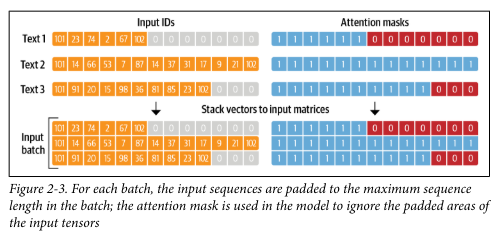

In [30]:
def tokenize(batch):
    return distilbert_tokenizer(batch['text'], padding=True, truncation=True)

emotions_encoded = emotions.map(
    tokenize, batched=True, batch_size=None
)

print(emotions_encoded["train"].column_names)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


## Training a Text Classifier

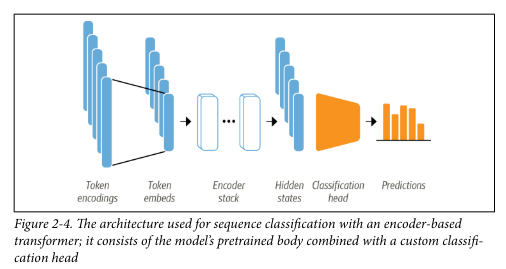

- Token encoding: one hot encoded text
- Embeddings

### Transformers as Feature Extractors
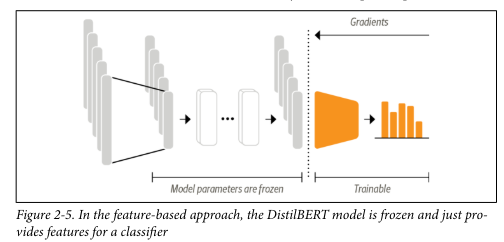

In [1]:
from transformers import AutoModel
import torch

model_chkpt = 'distilbert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModel.from_pretrained(model_chkpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Tensorflow models
- `from transformers import TFAutoModel`
- `tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base")`
    - you will get an error in the previous line
- `tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)`
    - here you have said from_pt = True, the weights are converted from pytroch weights to tensorflow weights

### Extracting the last hidden states

In [2]:
from transformers import AutoTokenizer

model_chkpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_chkpt)


text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


- inputs.items(): gives a dictionary
    - inputs
    - attention mask
    
- ** for keyword argument
- the parameters should be named in a dictionary
- can pass into a function

In [6]:
inputs = {k:v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [7]:
outputs.last_hidden_state.size()
# [batch_size, n_token, hidden_dim]

torch.Size([1, 6, 768])

In [ ]:
def extract_hidden_state(batch):
    inputs = {k:v.to(device) for k, v in input.items() 
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        
    # return vector for [CLS] token
    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

## Sum up the training process

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch

import numpy as np

model_chkpt = 'distilbert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

emotions = load_dataset('emotion')
# emotions = emotions['train']

tokenizer = AutoTokenizer.from_pretrained(model_chkpt)
model = AutoModel.from_pretrained(model_chkpt).to(device)


# need to tokenize the data
# need to define a function to tokenize the data in batch
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

emotions_encoded = emotions_encoded = emotions.map(
    tokenize, batched=True, batch_size=None
)

print(emotions_encoded.column_names)

emotions_encoded.set_format(
    'torch', columns=['input_ids', 'attention_mask', 'label']
)

# to extract hidden state
    # function to extract
    # use map method
    
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k, v in batch.items() 
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # return vector for [CLS] token
    return {'hidden_state': last_hidden_state[:,0].cpu().numpy()}

emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=4)
print('emotions data for trianing')
print(emotions_hidden.column_names)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'train': ['text', 'label', 'input_ids', 'attention_mask'], 'validation': ['text', 'label', 'input_ids', 'attention_mask'], 'test': ['text', 'label', 'input_ids', 'attention_mask']}


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

emotions data for trianing
{'train': ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'], 'validation': ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'], 'test': ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']}


In [7]:
import numpy as np

X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
Y_train = np.array(emotions_hidden['train']['label'])
Y_valid = np.array(emotions_hidden['validation']['label'])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

- UMAP to convert multi-dim to 2 dim
    - uniform manifold approximation and projection for dimension reduction
- `!pip install umap-learn`
- UMAP works on the values ranging from [0, 1]
- MinMaxScalar

In [11]:
# ! pip install umap-learn

from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
# what is metric?
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = Y_train
df_emb.head()

,X,Y,label
0,4.275496,6.294339,0
1,-2.987195,5.444882,0
2,5.556536,2.694399,3
3,-2.122870,3.328178,2
4,-3.278974,3.285664,3


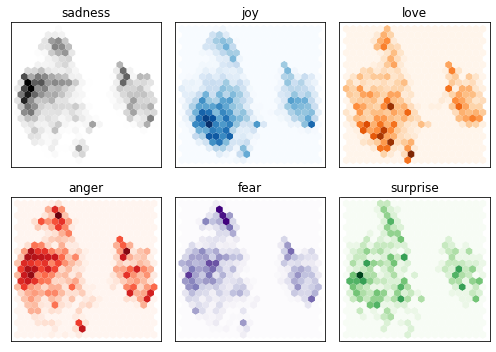

In [15]:
import  matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten() #?
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    # query a dataframe using an expression
    axes[i].hexbin(
        df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
        gridsize=20, linewidths=(0,)
    )
    
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()